# Shopee Product Classification 

Notebook to experiment over several Neural Networks over the product dataset obtained from Shopee and evaluate results.

The following models are evaluated as part of this notebook:

Baseline 1: CNN <br>
Baseline 2: CNN with augmented layers <br>
Improvement 1: Adding RNN <br>
Improvement 2: Adding attention

## Imports and Config

In [1]:
!pip install scikit-image
!pip install shopee_crawler
!pip install torchvision
!pip install opencv-python

You should consider upgrading via the 'c:\users\shubh\.pyenv\pyenv-win\versions\3.7.9\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\shubh\.pyenv\pyenv-win\versions\3.7.9\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\shubh\.pyenv\pyenv-win\versions\3.7.9\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\shubh\.pyenv\pyenv-win\versions\3.7.9\python.exe -m pip install --upgrade pip' command.


In [6]:
# System
import os
import sys
import json
import importlib
from tqdm import tqdm

# Data
import numpy as np
import pandas as pd
from collections import Counter

# Visualization
import ipywidgets as widgets
import matplotlib.pyplot as plt

# Custom Modules
from scripts import crawler
from utils import file_utils, device_utils
from model import trainer, dataset, baseline_cnn_1, rnn_cnn


import cv2
import torch
import torch.nn as nn
from torchvision.models import ResNet18_Weights
from torchvision import transforms, models, datasets

from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score

In [71]:
# Can use this to reload file when editing for faster changes (Will remove when finally submitting)
importlib.reload(rnn_cnn)

<module 'model.rnn_cnn' from 'C:\\Users\\shubh\\Desktop\\NUS\\Semester Two\\Neural Networks I\\cs5242-project\\model\\rnn_cnn.py'>

## Data Load

In [8]:
image_dir = 'data/images'

In [9]:
if(file_utils.check_images_dir()):
    print(f'Images already exist at: {file_utils.images}')
elif(file_utils.check_tar_exists()):
    print(f'Images not yet extracted')
    print(f'Image zip exists at: {file_utils.images_zip}')
    file_utils.extract_tar()
else:
    print(f'Images need to be downloaded')
    for c in category_urls:
        get_category_data('data', c)
    download_images('data')

Images already exist at: data/images


## Note: To be in accordance with other folders, changes to make:
- Add "-cat" to Women's Apparel directory after unzipping (Maybe we handle when we're zipping itself? Otherwise we can add a condition for this in the dataloader too)

## Dataset

In [10]:
data = dataset.DataSet(max_num_img=300)

<BarContainer object of 24 artists>

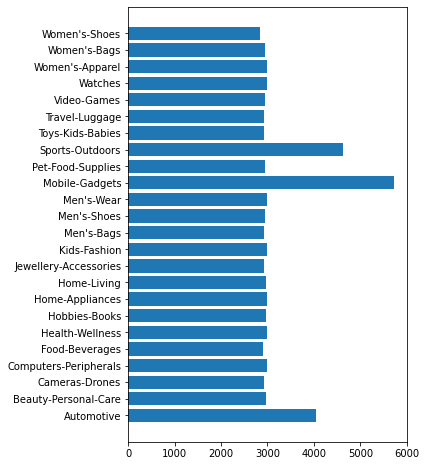

In [11]:
cats, items = zip(*data.image_count_per_category().items())
fig, ax = plt.subplots(figsize=(5, 8))
ax.barh(cats, items)

In [12]:
data.load_all()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 138.03it/s]


In [13]:
all_categories = data.categories
widgets.interact_manual.opts['manual_name'] = 'Show samples'
im = widgets.interact_manual(lambda category: data.plot_samples(category), category=all_categories)

interactive(children=(Dropdown(description='category', options=('Automotive', 'Beauty-Personal-Care', 'Cameras…

## Model Configurations

In [14]:
batch_size = 32
num_epoch = 5

In [72]:
rnn_model = rnn_cnn.CNNWithRNN(len(data.categories))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=5e-4)

In [ ]:
mtrainer = trainer.Trainer(rnn_model, optimizer, criterion, data, batch_size)
mtrainer.run_train(num_epoch)

epoch   0 |   100 batches loss: 3.1797
[Epoch   0]: Training loss: 3.173605 | Accuracy: 0.053373
[Epoch   0]: Validation loss: 3.164700 | Accuracy: 0.073611 | Within 3: 0.175000
epoch   1 |   100 batches loss: 3.1363


## CNN Baseline Model

In [136]:
baseline_cnn_1_model = baseline_cnn_1.BaselineCNN1(len(data.categories))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseline_cnn_1_model.parameters(), lr=5e-4)

In [137]:
mtrainer = trainer.Trainer(baseline_cnn_1_model, optimizer, criterion, data, batch_size)
mtrainer.run_train(num_epoch)

epoch   0 |   100 batches loss: 3.0903
[Epoch   0]: Training loss: 3.078083 | Accuracy: 0.082341
[Epoch   0]: Validation loss: 3.010318 | Accuracy: 0.106944
epoch   1 |   100 batches loss: 2.9653
[Epoch   1]: Training loss: 2.958160 | Accuracy: 0.120635
[Epoch   1]: Validation loss: 2.937470 | Accuracy: 0.131944


In [138]:
test_loss, test_acc, incorect_stats = mtrainer.run_test(mtrainer.testloader, True)
print(f'Accuracy of the network on the test images: {test_acc*100} %')

Accuracy of the network on the test images: 12.01388888888889 %


In [151]:
cnn_layers = list(list(baseline_cnn_1_model.children())[0]._modules.values())
cnn_layers.append(list(baseline_cnn_1_model.children())[1]) #Adding adaptive pool
image = data[np.random.randint(len(data.images))][0]
outputs = []
names = []
for layer in cnn_layers:
    if('BatchNorm2d' in str(layer)):
        image = torch.unsqueeze(image, 0)
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
cnn_layers

[Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True,

In [140]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())

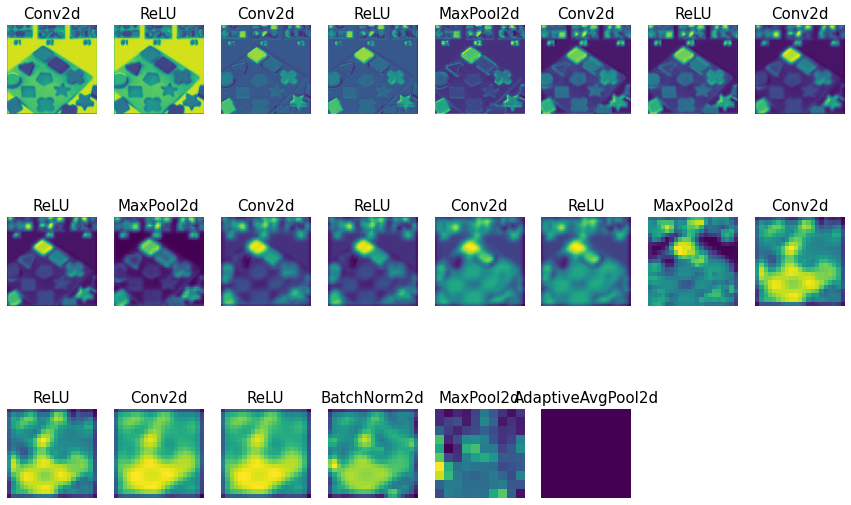

In [141]:
fig = plt.figure(figsize=(15, 10))
for i in range(len(processed)):
    a = fig.add_subplot(3, 8, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=15)

IndexError: list index out of range

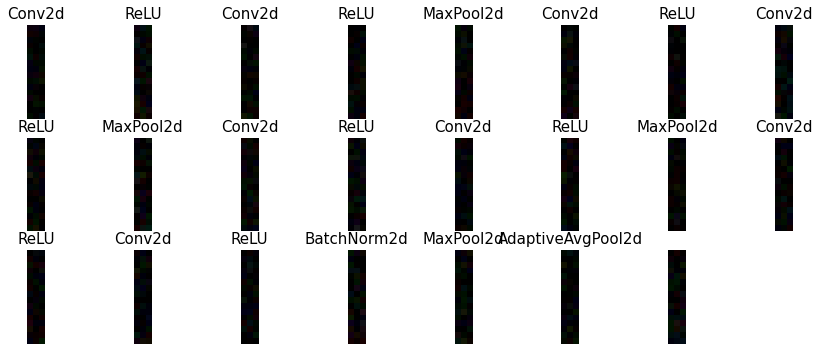

In [158]:
layer = 5
filters = cnn_layers[layer]._parameters['weight']
fig = plt.figure(figsize=(15, 10))
for i in range(len(filters)):
    a = fig.add_subplot(len(filters)//8+1, 8, i+1)
    imgplot = plt.imshow(filters[i].detach().numpy())
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=15)